In [ ]:
!pip install transformers

In [ ]:
"""https://huggingface.co/dataset/roberta-base-squad2"""
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline
model_name = "deepset/roberta-base-squad2"
# a) Get predictions
nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)
QA_input = {
    'question': 'Why is model conversion important?',
    'context': 'The option to convert models between FARM and transformers gives freedom to the user and let people easily switch between frameworks.'
}
res = nlp(QA_input)
# b) Load model & tokenizer
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


QA Metrics Material

In [ ]:
res # score == F1 Score: It's computed on the individual words in the prediction vs the true words provided in context

{'score': 0.21171385049819946,
 'start': 59,
 'end': 84,
 'answer': 'gives freedom to the user'}

RoBERTa Architecture

In [ ]:
model

RobertaForQuestionAnswering(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Lay

How to fine-tune a QA Model?

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
squad = load_dataset("squad")

In [ ]:
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [ ]:
squad["train"][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

In [ ]:
# Preprocess the data to a BERT format
def preprocess_function(examples):
  """Courtesy of https://huggingface.co/docs/transformers/tasks/question_answering"""
  questions = [q.strip() for q in examples["question"]]
  inputs = tokenizer(
      questions,
      examples["context"],
      max_length=384,
      truncation="only_second",
      return_offsets_mapping=True,
      padding="max_length",
  )
  offset_mapping=inputs.pop("offset_mapping")
  answers = examples["answers"]
  start_positions = []
  end_positions = []
  for i, offset in enumerate(offset_mapping):
    answer = answers[i]
    start_char = answer["answer_start"][0]
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context
    idx = 0
    while sequence_ids[idx] != 1:
      idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
      idx += 1
    context_end = idx - 1

    # If the answer is not fully inside the context, label it (0, 0)
    if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
      start_positions.append(0)
      end_positions.append(0)
    else:
      # Otherwise it's the start and end token positions
      idx = context_start
      while idx <= context_end and offset[idx][0] <= start_char:
        idx += 1
      start_positions.append(idx - 1)

      idx = context_end
      while idx >= context_start and offset[idx][1] >= end_char:
        idx -= 1
      end_positions.append(idx + 1)
  inputs["start_positions"] = start_positions
  inputs["end_positions"] = end_positions
  return inputs

In [ ]:
tokenized_squad = squad.map(preprocess_function, batched=True, remove_columns=squad["train"].column_names)

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [ ]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator()

CPU Training Result... Let's think about GPU's okay?

In [ ]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
model = AutoModelForQuestionAnswering.from_pretrained(model_name) #remember that model_name is deepset/roberta-base-squad2

In [ ]:
!pip install -U transformers[torch]

In [ ]:
!pip install accelerate -U

In [ ]:
# Let's start training!
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=0.01,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=11,
    num_train_epochs=1,
    weight_decay=0.01,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_squad["train"],
    eval_dataset=tokenized_squad["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


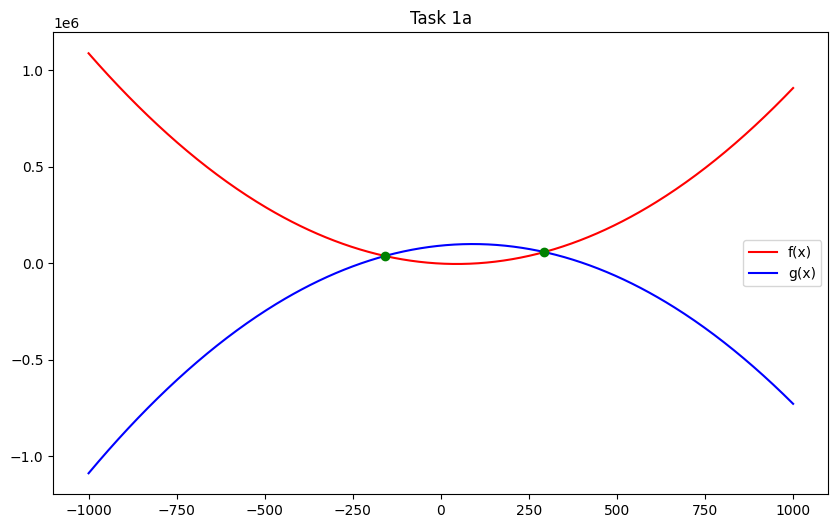

Task 1a:
1a. Intersection point 1: (-158.622201475220, 37412.000933615098)
1a. Intersection point 2: (293.622201475220, 57762.999066384902)


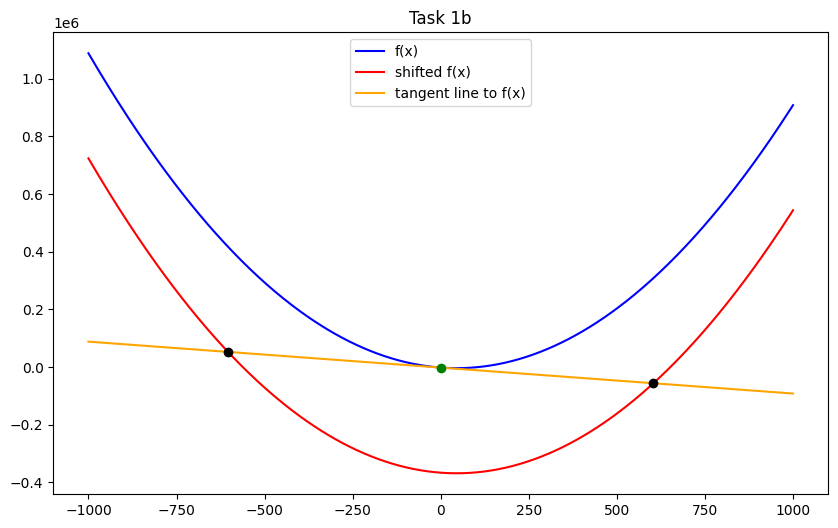

Task 1b:
Equation of the tangent line to the curve f(x): -90x - 2025
1b. Intersection point 1: (-603.7383539249432, 52311.45185324489)
1b. Intersection point 2: (603.7383539249432, -56361.45185324489)

Task 1c:
1c. Equation of the tangent line 1 to the curve f(x): -1294.11793442337x + -364500
1c. Equation of the tangent line 2 to the curve f(x): 1114.11793442337x + -364500


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import math as m

#Task 1a
#Định nghĩa hàm f(x) and g(x)
def f(x, A):
    return x**2 - 2*A*x - A**2
def g(x, A):
    return -x**2 + 4*A*x + A**3
#Chọn giá trị cho A
A=45
#Xác định biến tượng trưng
x=sp.symbols('x')
#Xác định các hàm tượng trưng
f_symbolic_function= x**2-2*A*x-A**2
g_symbolic_function= -x**2+4*A*x+A**3
#Tìm các điểm giao nhau một cách tượng trưng
intersection_points_symbolic=sp.solve(f_symbolic_function - g_symbolic_function,x)
#Chuyển đổi các điểm giao nhau thành giá trị số
intersection_points_to_numerical_values=[float(point.evalf()) for point in intersection_points_symbolic]
#Tính giá trị y của các điểm giao nhau
the_y_values_of_intersection_points=[f(point, A) for point in intersection_points_to_numerical_values]
#Vẽ các hàm trên
x_values = np.linspace(-1000, 1000, 500)
plt.figure(figsize=(10, 6))
plt.plot(x_values, f(x_values, A), label='f(x)',color='red')
plt.plot(x_values,g(x_values, A), label='g(x)', color='blue')
plt.scatter(intersection_points_to_numerical_values, the_y_values_of_intersection_points,color='green',zorder=50)
#Thêm tiêu đề và chú thích
plt.title('Task 1a')
plt.legend(loc='center right')
# plt.grid(True)
plt.show()
print("Task 1a:")
#In ra các điểm giao nhau
for i, (x_value, y_value) in enumerate(zip(intersection_points_to_numerical_values, the_y_values_of_intersection_points),start=1):
    print(f"1a. Intersection point {i}: ({x_value:.12f}, {y_value:.12f})")


#Task 1b
A=45
#Định nghĩa các hàm theo đề yêu cầu
def f(x):
    return x**2 - 2*A*x - A**2
def f_shifted(x):
    return x**2 - 2*A*x - A**2 - 4*A**3
#Phương trình đường tiếp tuyến T tại (0, -A**2)
def tangent_line(x):
    return -2*A*x - A**2
#Tìm các điểm giao nhau của f_shifted(x) và đường tiếp tuyến
#Giải phương trình f_shifted(x) = tangent_line(x)
# x**2 - 2*A*x - A**2 - 4*A**3 = -2*A*x - A**2
#Đơn giản hóa thành x**2 = 4*A**3
#Vì vậy, x = ±sqrt(4*A**3)
x_intersection1= -np.sqrt(4*A**3)
x_intersection2= np.sqrt(4*A**3)
y_intersection1=tangent_line(x_intersection1)
y_intersection2=tangent_line(x_intersection2)
#Tạo giá trị x để vẽ đồ thị
x = np.linspace(-1000, 1000, 500)
#Tiến hành vẽ đồ thị
plt.figure(figsize=(10,6))
plt.plot(x,f(x),label='f(x)', color='blue')
plt.plot(x,f_shifted(x), label='shifted f(x)',color='red')
plt.plot(x, tangent_line(x),label='tangent line to f(x)',color='orange')
#Vẽ thêm điểm tiếp tuyến
plt.scatter(0, -A**2, color='green',zorder=50)
#Vẽ thêm các điểm giao nhau
plt.scatter([x_intersection1, x_intersection2], [y_intersection1, y_intersection2],color='black',zorder=50)
#Thêm tiêu đề và chú thích cho đồ thị
plt.title('Task 1b')
# plt.xlabel('x')
# plt.ylabel('y')
plt.legend(loc='upper center')
#Hiển thị đồ thị
plt.show()
print("Task 1b:")
#Phương trình đầu ra của đường tiếp tuyến và các điểm giao nhau
tangent_line_equation=f"{-2*A}x - {A**2}"
print("Equation of the tangent line to the curve f(x):", tangent_line_equation)
print(f"1b. Intersection point 1: ({x_intersection1}, {y_intersection1})")
print(f"1b. Intersection point 2: ({x_intersection2}, {y_intersection2})")


# Task 1c
#Chọn giá trị cho A
A = 45
#Xác định các hàm và đạo hàm của chúng
x = sp.symbols('x')
f_expression = x**2 - 2*A*x - A**2
g_expression = -x**2 + 4*A*x + A**3
f_prime_expression = sp.diff(f_expression, x)
#Xác định điểm đã cho
x0 = 0
y0 = -4 * A**3
#Tìm các điểm tiếp tuyến
a = sp.symbols('a')
tangent_equation = y0 - (a**2 - 2*A*a - A**2) + a * (2*a - 2*A)
a_solutions = sp.solve(tangent_equation, a)
a_solutions = [solution.evalf() for solution in a_solutions if solution.evalf() != 0]
#Tính giá trị y của các điểm tiếp tuyến
tangential_points = [(a, a**2 - 2*A*a - A**2) for a in a_solutions]
#Tìm phương trình của các đường tiếp tuyến
tangent_lines = []
for a in a_solutions:
    slope = 2*a - 2*A
    intercept = y0 - slope * x0
    tangent_lines.append((slope, intercept))
print("\nTask 1c:")
for i, (slope, intercept) in enumerate(tangent_lines):
    print(f"1c. Equation of the tangent line {i+1} to the curve f(x): {slope}x + {intercept}")
#Vẽ hàm và các đường tiếp tuyến
x_values = np.linspace(-1000, 1000, 500)
f_values = [f_expression.subs(x, value) for value in x_values]
plt.figure(figsize=(10,6))
plt.plot(x_values, f_values, label='f(x)', color='blue')
colors = ['orange', 'green']
for i, (slope, intercept) in enumerate(tangent_lines):
    tangent_y_values = slope * x_values + intercept
    plt.plot(x_values, tangent_y_values, label=f'tangent line {i+1}', color=colors[i])
    plt.scatter(a_solutions[i], a_solutions[i]**2 - 2*A*a_solutions[i] - A**2, color=colors[i])
plt.scatter(x0, y0, color='red', zorder=50)  #Tọa độ (0, -4A**3)
plt.title('Task 1c')
plt.legend()
plt.show()

